<h2 align="center"> GRAPH CONSTRUCTION MODULE</h2>

<h3 align="center">Multi-Scale Driver Interactions Network</h3>
<h5>============================================================</h5>
<h4>This module constructs graph representations for:</h4>
<li align="center">1. Feature interaction graphs (variables as nodes)</li>
<li align="center">2. Spatial proximity graphs (locations as nodes)</li>
<li align="center">3. Hybrid spatio-temporal graphs</li>
<li align="center">4. Graph metrics and community detection</li>
<h5>============================================================</h5>

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist, squareform
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mutual_info_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import mutual_info_regression
import warnings
warnings.filterwarnings('ignore')

#### ============================================================================
<h3 align="center">SECTION 1: LOAD DATA AND PREPARE FEATURES</h3>

#### ============================================================================

In [2]:
print("\n📂 Loading data for graph construction...")

data = pd.read_csv('./data_output/multiscale_integrated_data.csv')
print(f"✅ Data loaded: {data.shape}")

# Feature categories
CLIMATE_FEATURES = ['temp_mean', 'temp_min', 'temp_max', 'temp_std',
                    'precip_total', 'precip_mean', 'precip_std',
                    'radiation_mean', 'dewpoint_mean', 'wind_mean', 'vpd']

SOIL_FEATURES = ['ph', 'clay', 'sand', 'silt', 'organic', 'nitrogen']

TOPO_FEATURES = ['elevation', 'slope', 'aspect', 'hillshade', 'tpi']

INTERACTION_FEATURES = ['temp_clay_interaction', 'precip_organic_interaction',
                        'temp_moisture_proxy', 'temp_elevation_interaction',
                        'precip_slope_interaction', 'sand_clay_ratio']

ALL_FEATURES = CLIMATE_FEATURES + SOIL_FEATURES + TOPO_FEATURES + INTERACTION_FEATURES
TARGET_VARIABLE = 'ndvi_max'

# Check for missing values
print(f"Missing values in features: {data[ALL_FEATURES].isnull().sum().sum()}")

# Handle missing values before standardization
data_clean = data.copy()
# Option 1: Remove rows with missing values
# data_clean = data_clean.dropna(subset=ALL_FEATURES)

# Option 2: Fill missing values with median (recommended for graph construction)
for feature in ALL_FEATURES:
    if data_clean[feature].isnull().any():
        median_val = data_clean[feature].median()
        data_clean[feature] = data_clean[feature].fillna(median_val)
        print(f"Filled missing values in {feature} with median: {median_val}")

print(f"Missing values after cleaning: {data_clean[ALL_FEATURES].isnull().sum().sum()}")

# Standardize features for graph construction
scaler = StandardScaler()
data_scaled = data_clean.copy()
data_scaled[ALL_FEATURES] = scaler.fit_transform(data_clean[ALL_FEATURES])


📂 Loading data for graph construction...
✅ Data loaded: (10000, 40)
Missing values in features: 33100
Filled missing values in elevation with median: 1876.0
Filled missing values in slope with median: 5.530774224682552
Filled missing values in aspect with median: 190.84056176229356
Filled missing values in hillshade with median: 184.0
Filled missing values in tpi with median: 1.8166666666666056
Filled missing values in temp_elevation_interaction with median: 28595.146846982247
Filled missing values in precip_slope_interaction with median: 3245.6546692413885
Missing values after cleaning: 0


#### ============================================================================
<h3 align="center">SECTION 2: FEATURE INTERACTION GRAPH (Variables as Nodes)</h3>

#### ============================================================================

In [3]:
def build_feature_interaction_graph(data, features, method='pearson', threshold=0.3):
    """
    Build graph where nodes = features, edges = correlations/MI
    
    Parameters:
    -----------
    data : DataFrame
        Input data with features
    features : list
        List of feature names
    method : str
        'pearson', 'spearman', or 'mutual_info'
    threshold : float
        Minimum correlation/MI score for edge creation
    
    Returns:
    --------
    G : networkx.Graph
        Feature interaction graph
    """
    print(f"Building feature interaction graph using {method}...")
    
    G = nx.Graph()
    
    # Add nodes with attributes (feature category)
    for feature in features:
        if feature in CLIMATE_FEATURES:
            category = 'climate'
            color = 'steelblue'
        elif feature in SOIL_FEATURES:
            category = 'soil'
            color = 'peru'
        elif feature in TOPO_FEATURES:
            category = 'topography'
            color = 'seagreen'
        else:
            category = 'interaction'
            color = 'orchid'
        
        G.add_node(feature, category=category, color=color)
    
    # Calculate pairwise relationships and add edges
    n_edges = 0
    
    for i, feat1 in enumerate(features):
        for j, feat2 in enumerate(features):
            if i < j:  # Avoid duplicates
                if method in ['pearson', 'spearman']:
                    # Remove any remaining NaN pairs for correlation
                    valid_data = data[[feat1, feat2]].dropna()
                    
                    if len(valid_data) < 2:  # Need at least 2 points for correlation
                        continue
                        
                    if method == 'pearson':
                        corr, _ = pearsonr(valid_data[feat1], valid_data[feat2])
                        weight = abs(corr)
                    elif method == 'spearman':
                        corr, _ = spearmanr(valid_data[feat1], valid_data[feat2])
                        weight = abs(corr)
                
                elif method == 'mutual_info':
                    # Discretize for mutual information
                    feat1_discrete = pd.cut(data[feat1], bins=10, labels=False, duplicates='drop')
                    feat2_discrete = pd.cut(data[feat2], bins=10, labels=False, duplicates='drop')
                    
                    # Remove NaN pairs for mutual information
                    valid_mask = ~(feat1_discrete.isna() | feat2_discrete.isna())
                    if valid_mask.sum() < 2:  # Need at least 2 points
                        continue
                        
                    feat1_valid = feat1_discrete[valid_mask]
                    feat2_valid = feat2_discrete[valid_mask]
                    
                    mi = mutual_info_score(feat1_valid, feat2_valid)
                    weight = mi
                    corr = mi
                
                # Add edge if above threshold
                if weight >= threshold:
                    G.add_edge(feat1, feat2, weight=weight, correlation=corr)
                    n_edges += 1
    
    print(f"✅ Graph created: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")
    return G

# Build multiple versions of feature graphs
print("\n🔗 Building feature interaction graphs...")
graph_pearson = build_feature_interaction_graph(data_clean, ALL_FEATURES, 
                                                method='pearson', threshold=0.3)
graph_spearman = build_feature_interaction_graph(data_clean, ALL_FEATURES, 
                                                 method='spearman', threshold=0.3)
graph_mi = build_feature_interaction_graph(data_clean, ALL_FEATURES, 
                                          method='mutual_info', threshold=0.05)

print("\n📊 Graph Summary:")
print(f"Pearson graph: {graph_pearson.number_of_nodes()} nodes, {graph_pearson.number_of_edges()} edges")
print(f"Spearman graph: {graph_spearman.number_of_nodes()} nodes, {graph_spearman.number_of_edges()} edges")
print(f"Mutual Info graph: {graph_mi.number_of_nodes()} nodes, {graph_mi.number_of_edges()} edges")


🔗 Building feature interaction graphs...
Building feature interaction graph using pearson...
✅ Graph created: 28 nodes, 112 edges
Building feature interaction graph using spearman...
✅ Graph created: 28 nodes, 96 edges
Building feature interaction graph using mutual_info...
✅ Graph created: 28 nodes, 276 edges

📊 Graph Summary:
Pearson graph: 28 nodes, 112 edges
Spearman graph: 28 nodes, 96 edges
Mutual Info graph: 28 nodes, 276 edges


#### ============================================================================
<h3 align="center">SECTION 3: VISUALIZE FEATURE INTERACTION GRAPHS</h3>

#### ============================================================================

✅ Graph visualization saved: ./data_output/graph_feature_pearson.png
✅ Graph visualization saved: ./data_output/graph_feature_mi.png


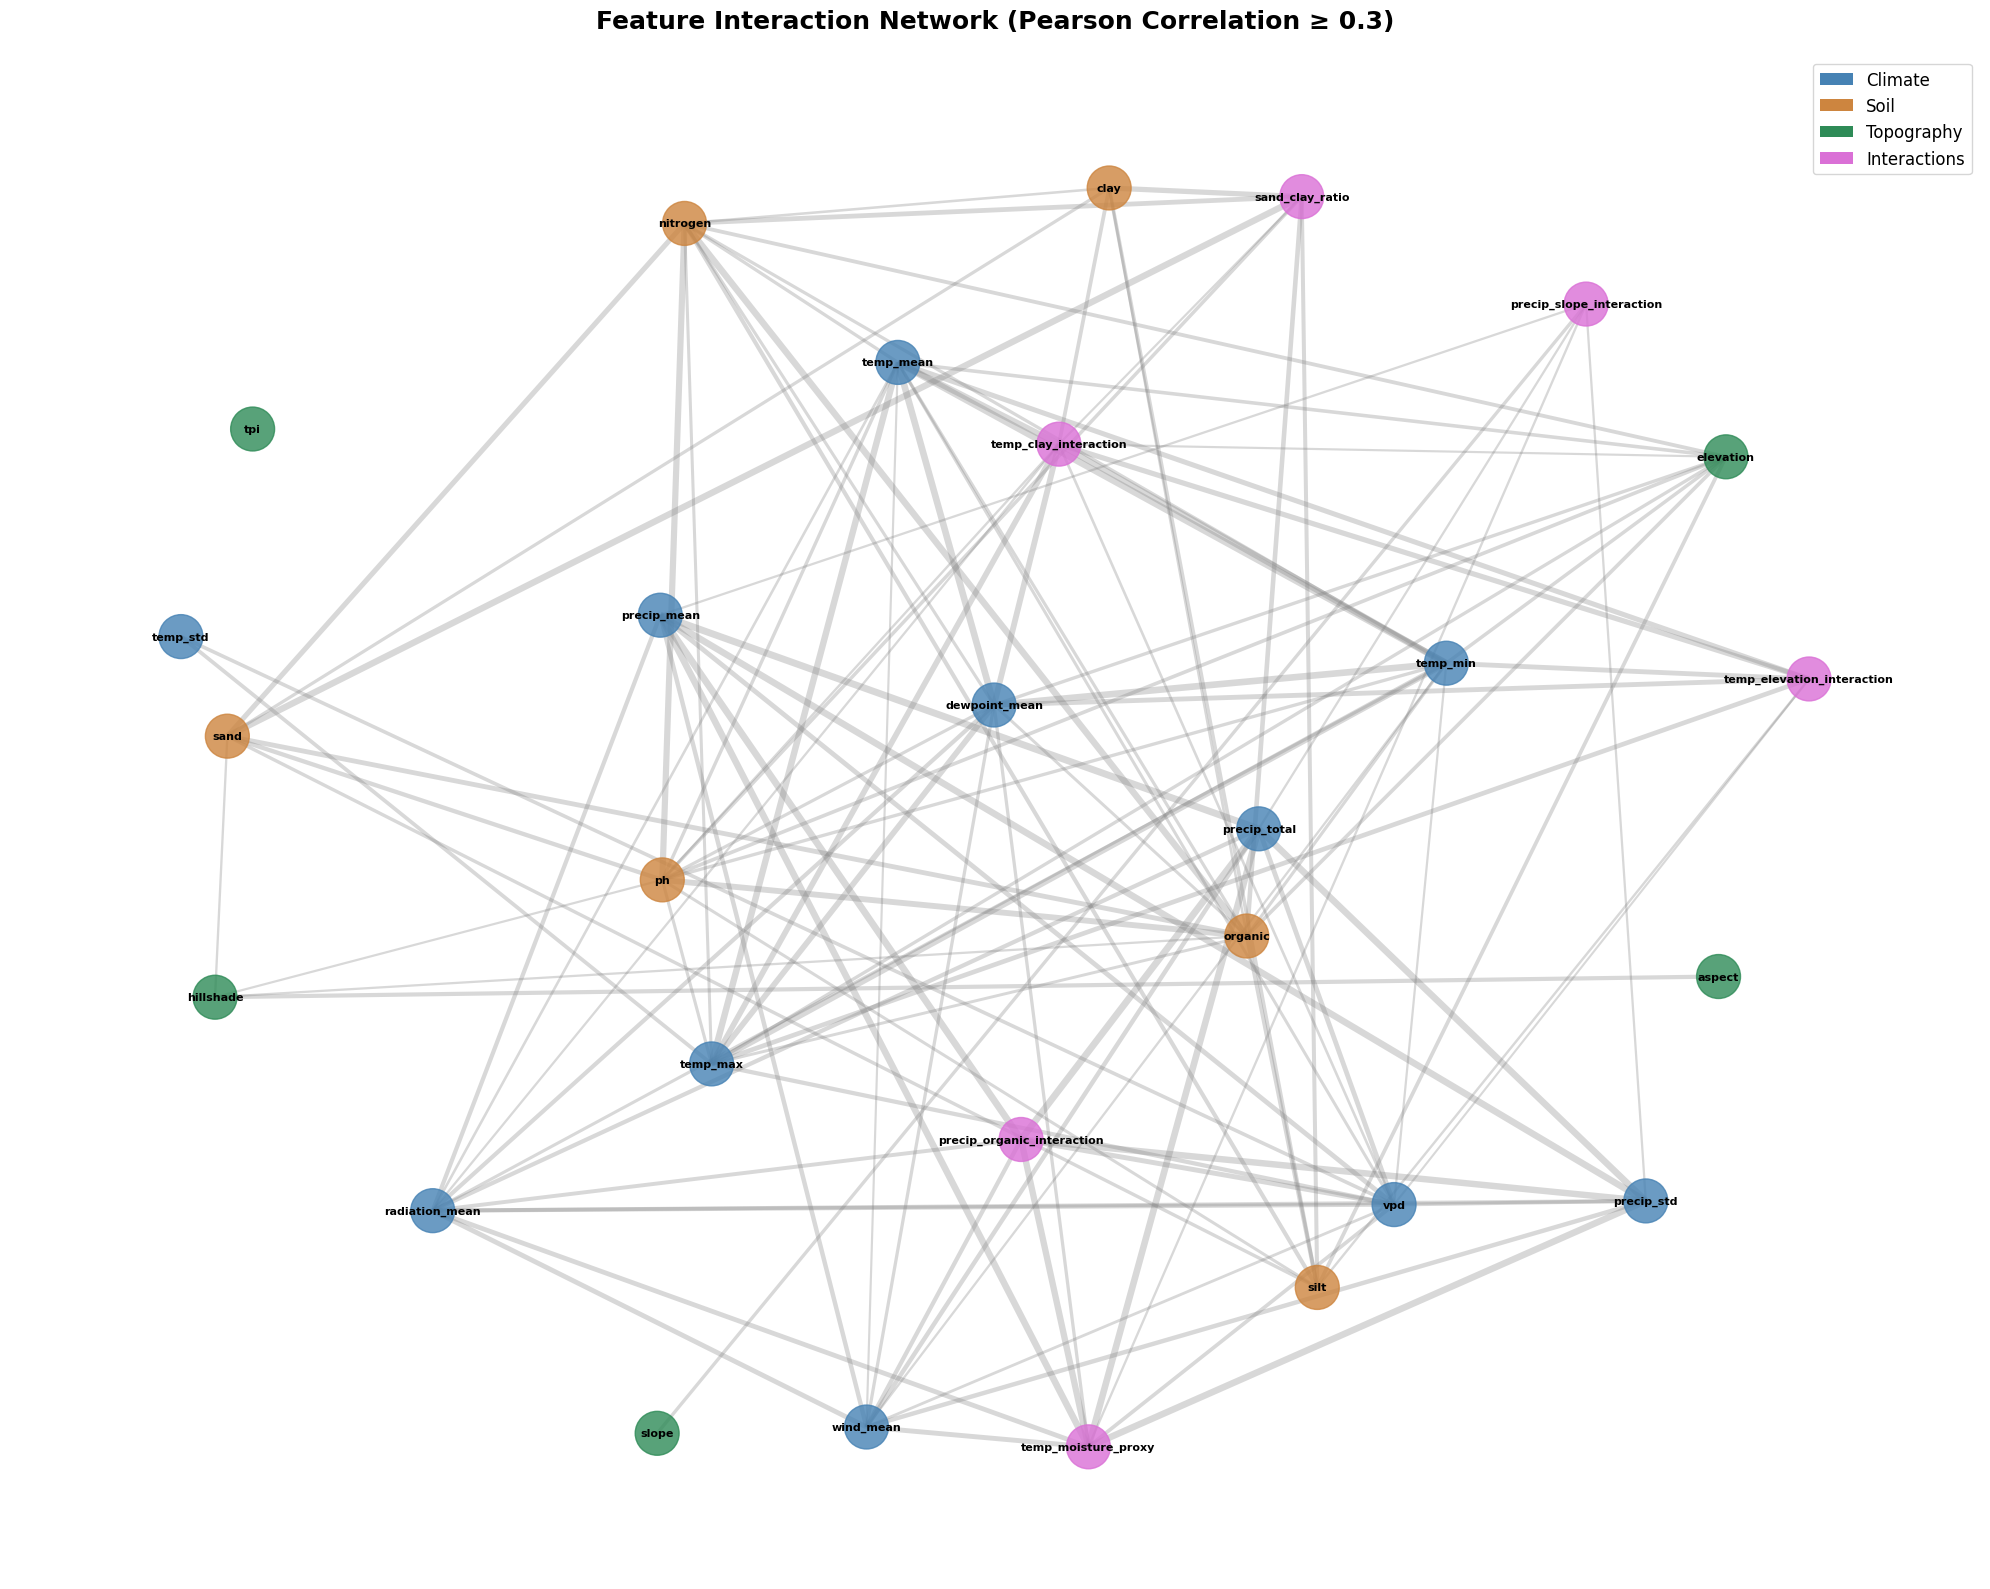

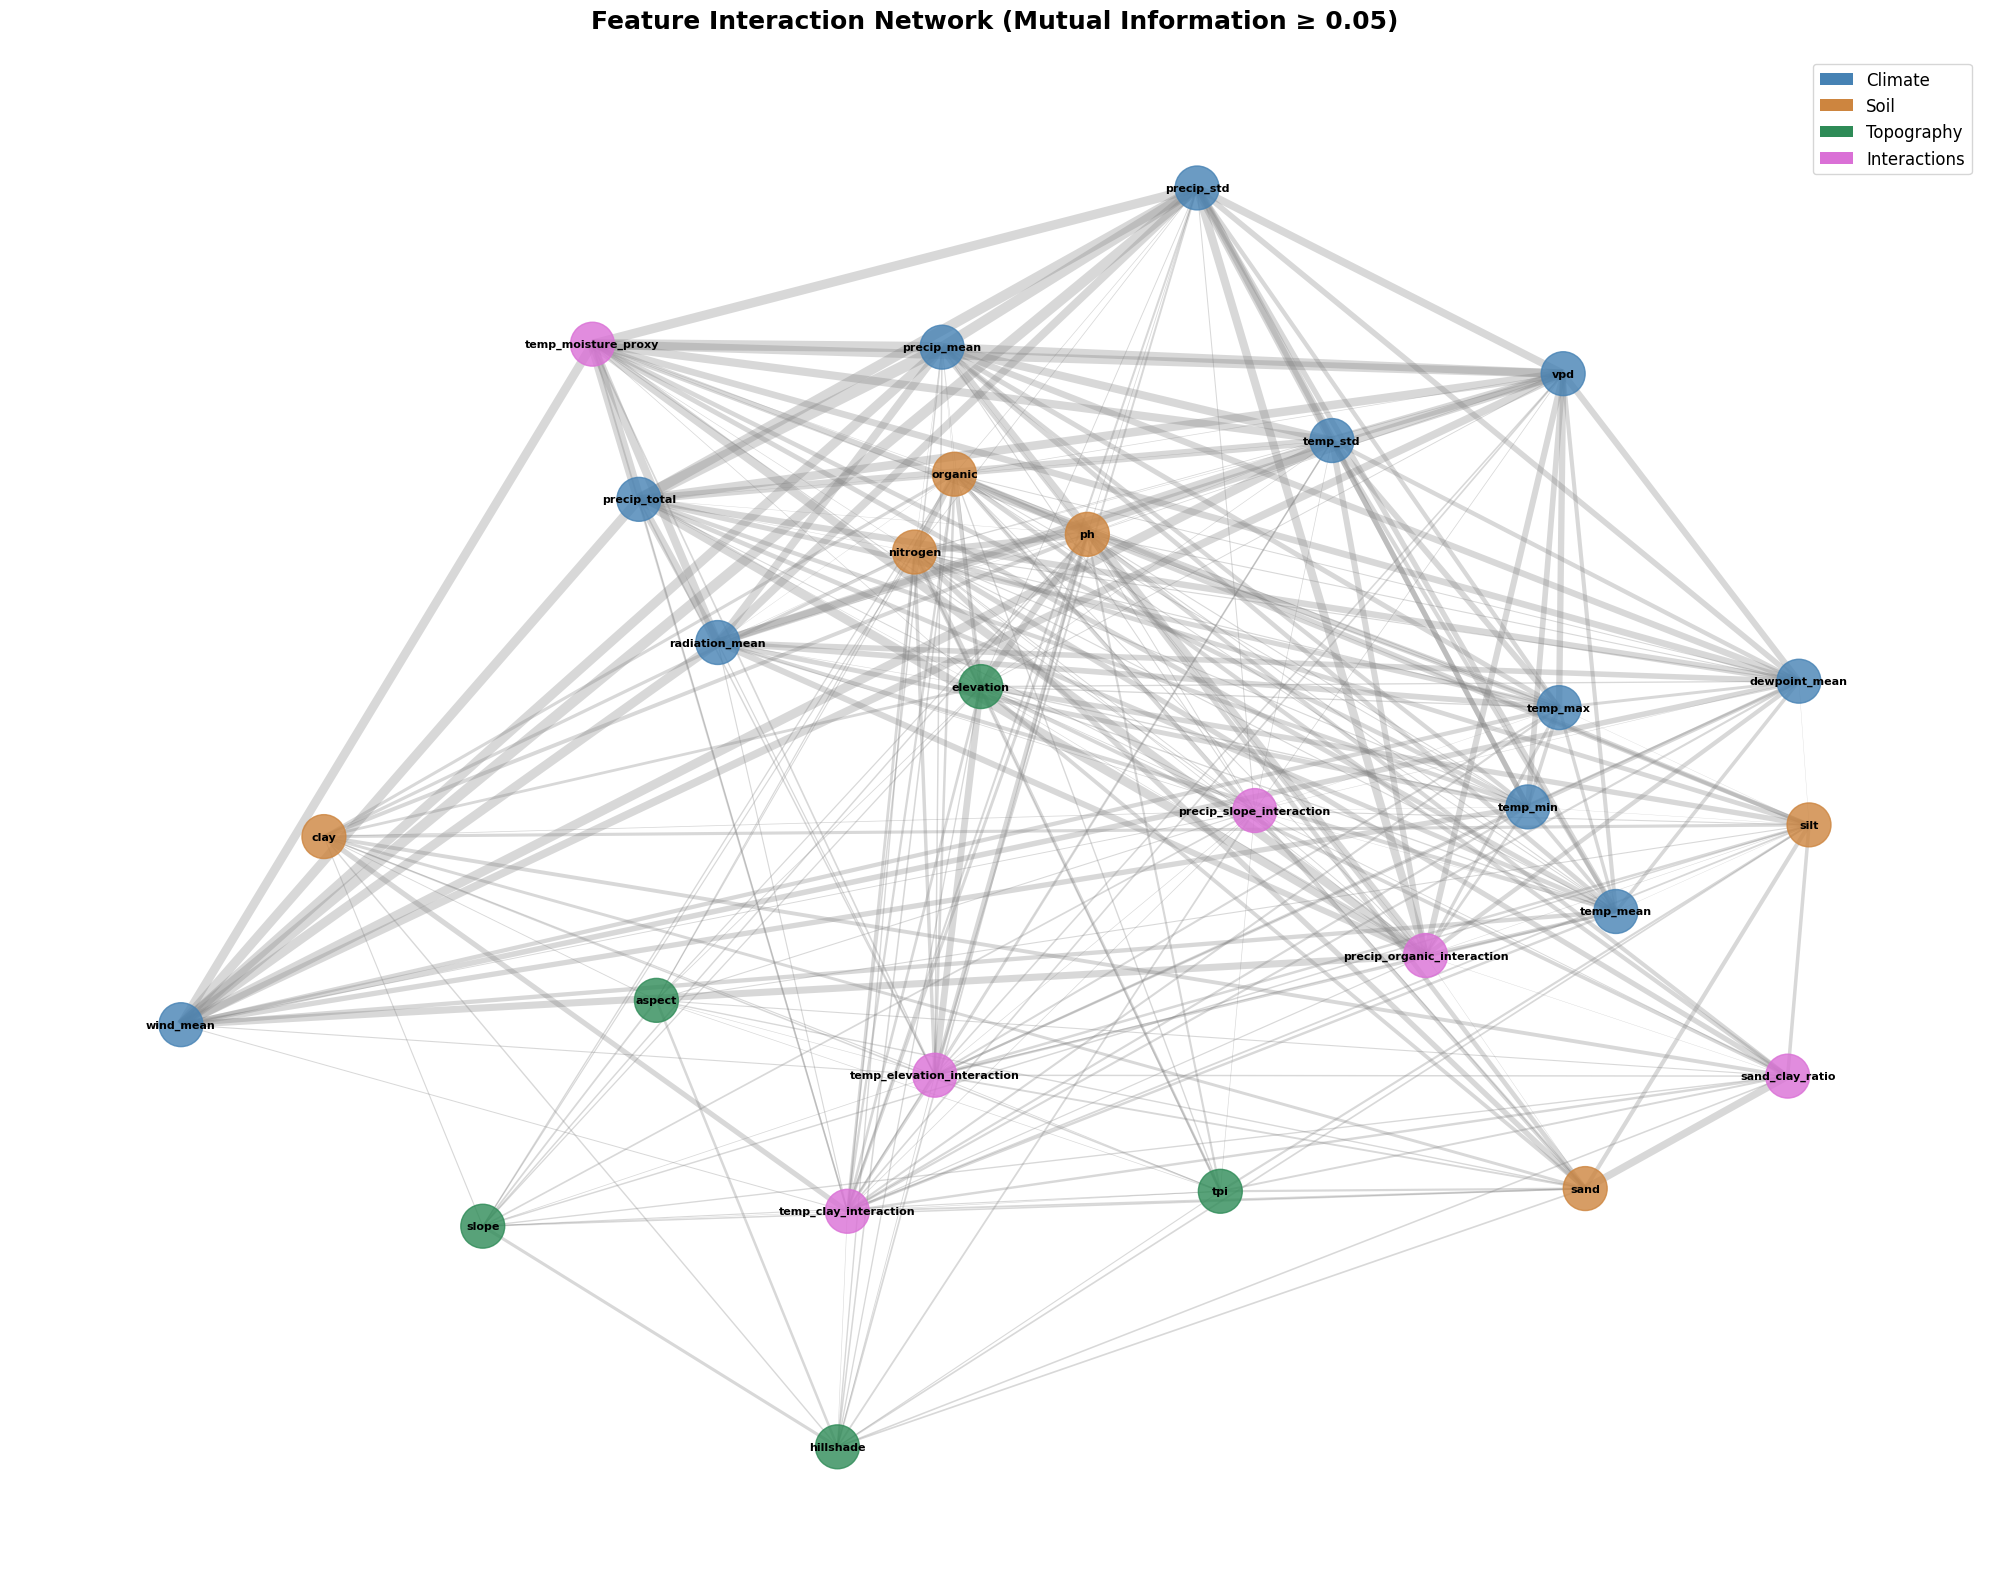

In [4]:
def visualize_feature_graph(G, title, filename, layout='spring'):
    """Visualize feature interaction graph with color-coded categories"""
    
    fig, ax = plt.subplots(figsize=(20, 16))
    
    # Layout algorithms
    if layout == 'spring':
        pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    elif layout == 'circular':
        pos = nx.circular_layout(G)
    elif layout == 'kamada_kawai':
        pos = nx.kamada_kawai_layout(G)
    
    # Get node colors from attributes
    node_colors = [G.nodes[node]['color'] for node in G.nodes()]
    
    # Get edge weights for width
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    edge_widths = [w * 5 for w in edge_weights]  # Scale for visibility
    
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          node_size=1000, alpha=0.8, ax=ax)
    
    # Draw edges with varying thickness
    nx.draw_networkx_edges(G, pos, width=edge_widths, 
                          alpha=0.3, edge_color='gray', ax=ax)
    
    # Draw labels
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold', ax=ax)
    
    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='steelblue', label='Climate'),
        Patch(facecolor='peru', label='Soil'),
        Patch(facecolor='seagreen', label='Topography'),
        Patch(facecolor='orchid', label='Interactions')
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=12)
    
    ax.set_title(title, fontsize=18, fontweight='bold', pad=20)
    ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✅ Graph visualization saved: {filename}")
    
    return fig

# Visualize graphs
fig1 = visualize_feature_graph(
    graph_pearson, 
    'Feature Interaction Network (Pearson Correlation ≥ 0.3)',
    './data_output/graph_feature_pearson.png',
    layout='spring'
)

fig2 = visualize_feature_graph(
    graph_mi, 
    'Feature Interaction Network (Mutual Information ≥ 0.05)',
    './data_output/graph_feature_mi.png',
    layout='kamada_kawai'
)

#### ============================================================================
<h3 align="center">SECTION 4: GRAPH METRICS AND CENTRALITY ANALYSIS</h3>

#### ============================================================================


📊 Analyzing Pearson Graph...

Basic Metrics:
  Nodes: 28
  Edges: 112
  Density: 0.2963
  Avg Degree: 8.0000
  Connected Components: 2
  Largest CC Size: 27
  Diameter (Largest CC): 6
  Avg Path Length (Largest CC): 2.1538
  Avg Clustering: 0.6175

Top 5 Nodes by Degree Centrality:
  vpd: 0.4815
  temp_mean: 0.4444
  temp_min: 0.4444
  dewpoint_mean: 0.4444
  ph: 0.4444

Top 5 Nodes by Betweenness Centrality:
  vpd: 0.1652
  temp_clay_interaction: 0.1339
  ph: 0.1225
  radiation_mean: 0.1026
  organic: 0.0912

Top 5 Nodes by Eigenvector Centrality:
  dewpoint_mean: 0.2976
  temp_mean: 0.2937
  temp_min: 0.2870
  temp_max: 0.2629
  temp_clay_interaction: 0.2429

📊 Analyzing Mutual Information Graph...

Basic Metrics:
  Nodes: 28
  Edges: 276
  Density: 0.7302
  Avg Degree: 19.7143
  Diameter: 2
  Avg Path Length: 1.2698
  Avg Clustering: 0.8968

Top 5 Nodes by Degree Centrality:
  temp_elevation_interaction: 1.0000
  precip_slope_interaction: 1.0000
  ph: 0.9630
  organic: 0.9630
  nit

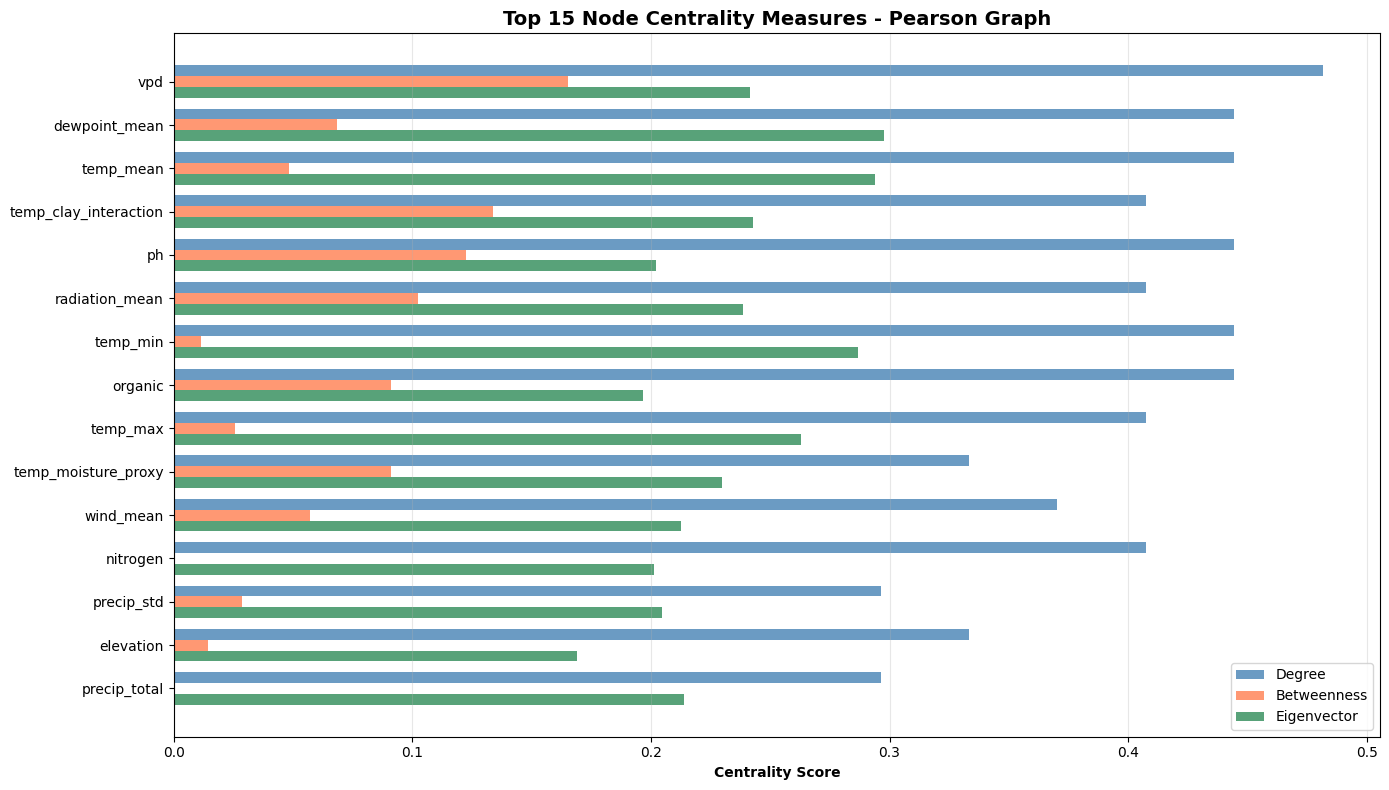

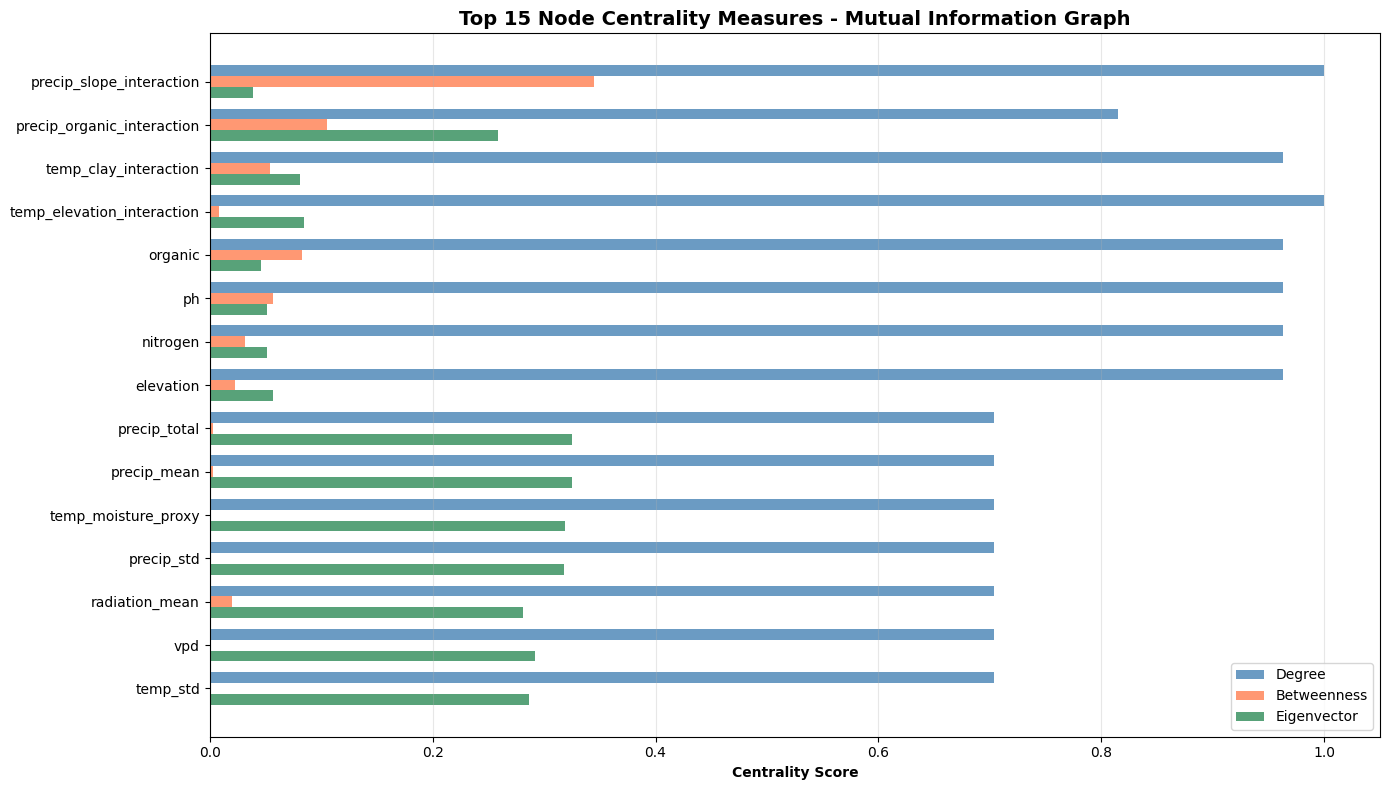

In [5]:
def analyze_graph_metrics(G, graph_name):
    """Compute and display graph metrics"""
    
    print(f"\n📊 Analyzing {graph_name}...")
    
    # Basic metrics
    metrics = {
        'Nodes': G.number_of_nodes(),
        'Edges': G.number_of_edges(),
        'Density': nx.density(G),
        'Avg Degree': sum(dict(G.degree()).values()) / G.number_of_nodes(),
    }
    
    # Check if connected
    if nx.is_connected(G):
        metrics['Diameter'] = nx.diameter(G)
        metrics['Avg Path Length'] = nx.average_shortest_path_length(G)
    else:
        largest_cc = max(nx.connected_components(G), key=len)
        G_largest = G.subgraph(largest_cc).copy()
        metrics['Connected Components'] = nx.number_connected_components(G)
        metrics['Largest CC Size'] = len(largest_cc)
        if len(largest_cc) > 1:
            metrics['Diameter (Largest CC)'] = nx.diameter(G_largest)
            metrics['Avg Path Length (Largest CC)'] = nx.average_shortest_path_length(G_largest)
    
    metrics['Avg Clustering'] = nx.average_clustering(G)
    
    # Centrality measures
    degree_cent = nx.degree_centrality(G)
    betweenness_cent = nx.betweenness_centrality(G, weight='weight')
    eigenvector_cent = nx.eigenvector_centrality(G, weight='weight', max_iter=1000)
    
    # Top central nodes
    top_degree = sorted(degree_cent.items(), key=lambda x: x[1], reverse=True)[:5]
    top_betweenness = sorted(betweenness_cent.items(), key=lambda x: x[1], reverse=True)[:5]
    top_eigenvector = sorted(eigenvector_cent.items(), key=lambda x: x[1], reverse=True)[:5]
    
    print("\nBasic Metrics:")
    for key, value in metrics.items():
        print(f"  {key}: {value:.4f}" if isinstance(value, float) else f"  {key}: {value}")
    
    print("\nTop 5 Nodes by Degree Centrality:")
    for node, cent in top_degree:
        print(f"  {node}: {cent:.4f}")
    
    print("\nTop 5 Nodes by Betweenness Centrality:")
    for node, cent in top_betweenness:
        print(f"  {node}: {cent:.4f}")
    
    print("\nTop 5 Nodes by Eigenvector Centrality:")
    for node, cent in top_eigenvector:
        print(f"  {node}: {cent:.4f}")
    
    return {
        'metrics': metrics,
        'degree_centrality': degree_cent,
        'betweenness_centrality': betweenness_cent,
        'eigenvector_centrality': eigenvector_cent
    }

# Analyze graphs
pearson_analysis = analyze_graph_metrics(graph_pearson, "Pearson Graph")
mi_analysis = analyze_graph_metrics(graph_mi, "Mutual Information Graph")

# Visualize centrality
def plot_centrality_comparison(analysis_dict, graph_name, filename):
    """Plot centrality measures for top nodes"""
    
    degree_cent = analysis_dict['degree_centrality']
    betweenness_cent = analysis_dict['betweenness_centrality']
    eigenvector_cent = analysis_dict['eigenvector_centrality']
    
    # Get top 15 nodes by average centrality
    avg_centrality = {}
    for node in degree_cent.keys():
        avg_centrality[node] = np.mean([
            degree_cent[node],
            betweenness_cent[node],
            eigenvector_cent[node]
        ])
    
    top_nodes = sorted(avg_centrality.items(), key=lambda x: x[1], reverse=True)[:15]
    top_node_names = [node for node, _ in top_nodes]
    
    # Prepare data
    degree_vals = [degree_cent[node] for node in top_node_names]
    between_vals = [betweenness_cent[node] for node in top_node_names]
    eigen_vals = [eigenvector_cent[node] for node in top_node_names]
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 8))
    
    x = np.arange(len(top_node_names))
    width = 0.25
    
    ax.barh(x - width, degree_vals, width, label='Degree', alpha=0.8, color='steelblue')
    ax.barh(x, between_vals, width, label='Betweenness', alpha=0.8, color='coral')
    ax.barh(x + width, eigen_vals, width, label='Eigenvector', alpha=0.8, color='seagreen')
    
    ax.set_yticks(x)
    ax.set_yticklabels(top_node_names)
    ax.set_xlabel('Centrality Score', fontweight='bold')
    ax.set_title(f'Top 15 Node Centrality Measures - {graph_name}', 
                 fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='x')
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✅ Centrality plot saved: {filename}")

plot_centrality_comparison(pearson_analysis, "Pearson Graph",
                          './data_output/graph_centrality_pearson.png')
plot_centrality_comparison(mi_analysis, "Mutual Information Graph",
                          './data_output/graph_centrality_mi.png')

#### ============================================================================
<h3 align="center">SECTION 5: SPATIAL PROXIMITY GRAPH (Locations as Nodes)</h3>

#### ============================================================================

Building spatial proximity graph (threshold: 0.1°)...
✅ Spatial graph: 1000 nodes, 472905 edges
✅ Spatial graph visualization saved: ./data_output/graph_spatial_proximity.png


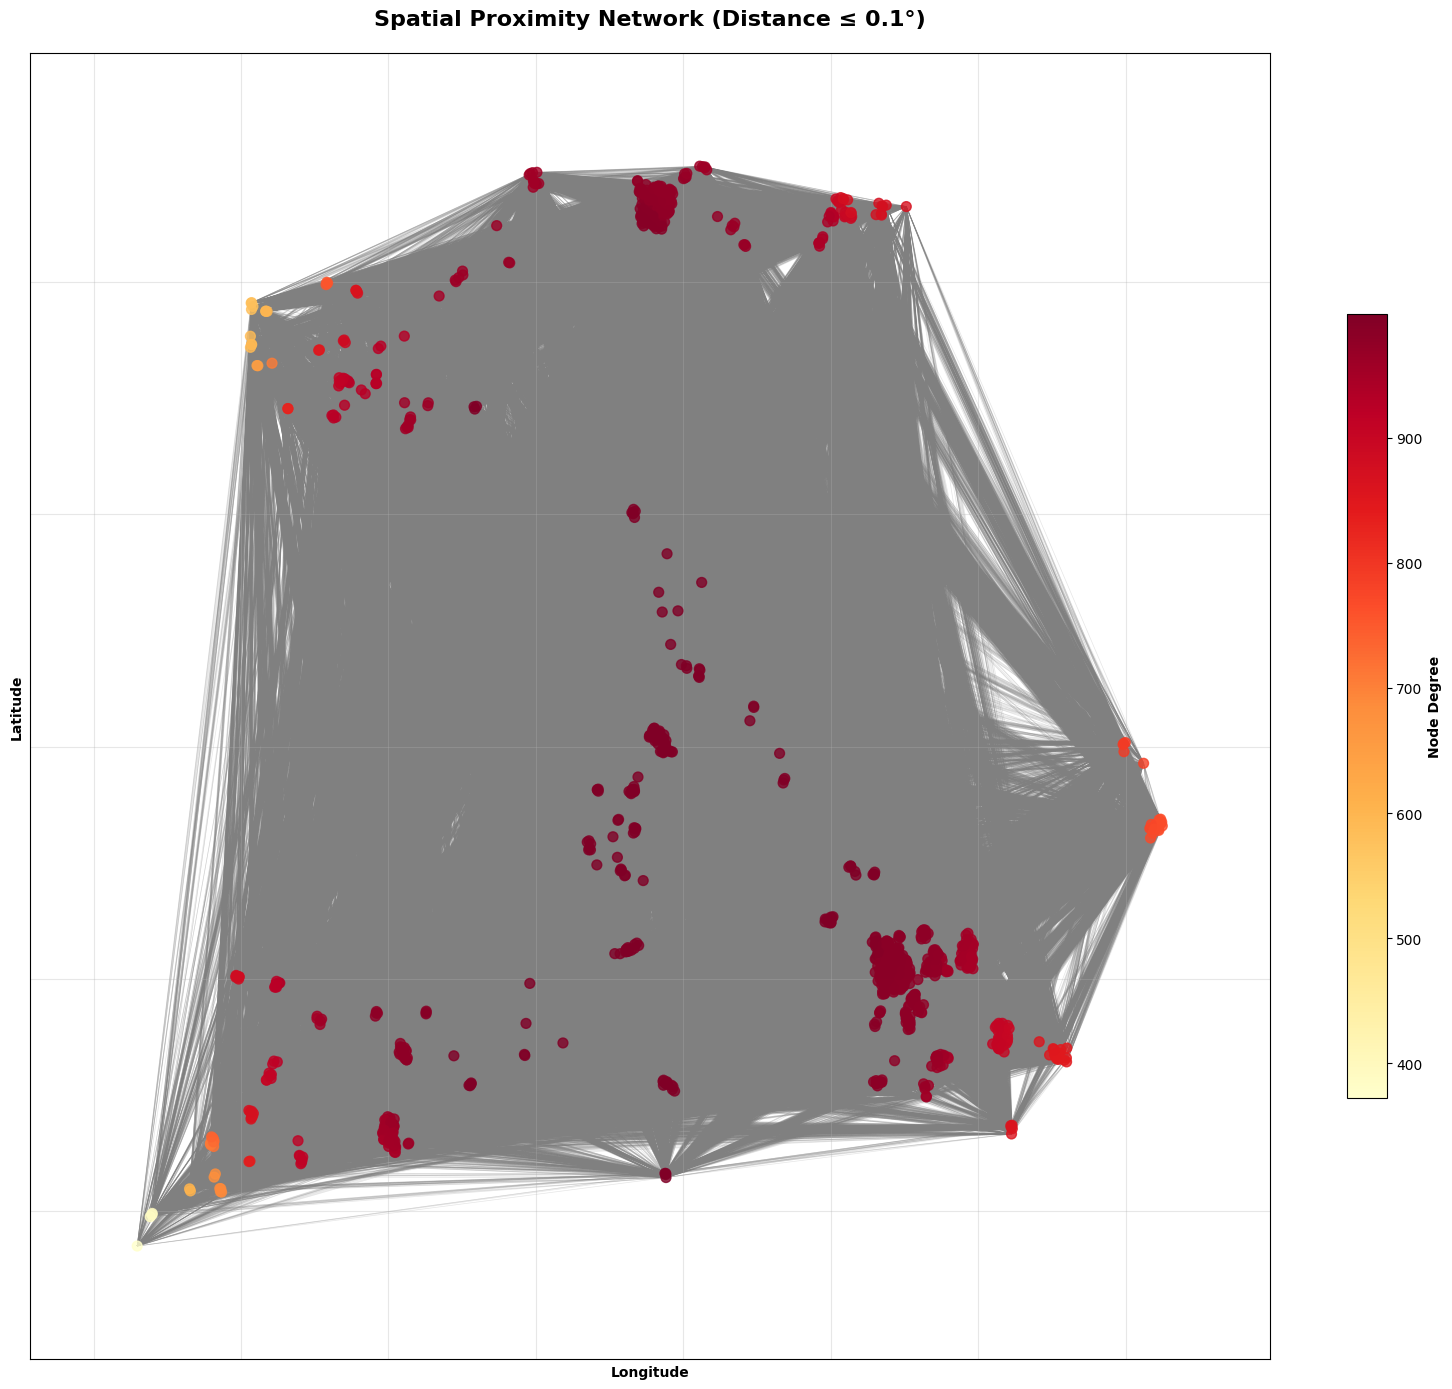

In [6]:
def build_spatial_graph(data, distance_threshold=0.1):
    """
    Build spatial graph where nodes = sampling locations
    Edges connect spatially proximate points
    
    Parameters:
    -----------
    data : DataFrame
        Must have 'longitude', 'latitude', 'index' columns
    distance_threshold : float
        Maximum distance (in degrees) for edge creation
    
    Returns:
    --------
    G_spatial : networkx.Graph
        Spatial proximity graph
    """
    print(f"Building spatial proximity graph (threshold: {distance_threshold}°)...")
    
    # Get unique locations
    locations = data[['index', 'longitude', 'latitude']].drop_duplicates('index')
    
    G_spatial = nx.Graph()
    
    # Add nodes with spatial coordinates
    for _, row in locations.iterrows():
        G_spatial.add_node(
            row['index'],
            pos=(row['longitude'], row['latitude']),
            lon=row['longitude'],
            lat=row['latitude']
        )
    
    # Calculate pairwise distances and add edges
    coords = locations[['longitude', 'latitude']].values
    distances = squareform(pdist(coords, metric='euclidean'))
    
    indices = locations['index'].values
    n_edges = 0
    
    for i in range(len(indices)):
        for j in range(i+1, len(indices)):
            dist = distances[i, j]
            if dist <= distance_threshold:
                G_spatial.add_edge(
                    indices[i], 
                    indices[j], 
                    weight=1/dist,  # Inverse distance as weight
                    distance=dist
                )
                n_edges += 1
    
    print(f"✅ Spatial graph: {G_spatial.number_of_nodes()} nodes, {G_spatial.number_of_edges()} edges")
    
    return G_spatial, locations

# Build spatial graph
spatial_graph, locations_df = build_spatial_graph(data, distance_threshold=0.1)

# Visualize spatial graph
def visualize_spatial_graph(G, locations, title, filename):
    """Visualize spatial graph with geographic layout"""
    
    fig, ax = plt.subplots(figsize=(16, 14))
    
    # Use actual geographic coordinates
    pos = {node: (G.nodes[node]['lon'], G.nodes[node]['lat']) for node in G.nodes()}
    
    # Node colors by degree (hub detection)
    degrees = dict(G.degree())
    node_colors = [degrees[node] for node in G.nodes()]
    
    # Draw
    nx.draw_networkx_edges(G, pos, alpha=0.2, width=0.5, edge_color='gray', ax=ax)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=50,
                          cmap='YlOrRd', alpha=0.8, ax=ax)
    
    # Add colorbar
    sm = plt.cm.ScalarMappable(cmap='YlOrRd', 
                               norm=plt.Normalize(vmin=min(node_colors), 
                                                 vmax=max(node_colors)))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, shrink=0.6)
    cbar.set_label('Node Degree', fontweight='bold')
    
    ax.set_title(title, fontsize=16, fontweight='bold', pad=20)
    ax.set_xlabel('Longitude', fontweight='bold')
    ax.set_ylabel('Latitude', fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✅ Spatial graph visualization saved: {filename}")

visualize_spatial_graph(
    spatial_graph, 
    locations_df,
    'Spatial Proximity Network (Distance ≤ 0.1°)',
    './data_output/graph_spatial_proximity.png'
)

#### ============================================================================
<h3 align="center">SECTION 6: COMMUNITY DETECTION</h3>

#### ============================================================================


Detecting communities in Feature Pearson Graph...
✅ Louvain: 4 communities
✅ Greedy: 4 communities
✅ Community visualization saved: ./data_output/graph_communities_features.png

📊 Community Composition:

Community 1 (10 features):
  - aspect (topography)
  - clay (soil)
  - elevation (topography)
  - hillshade (topography)
  - nitrogen (soil)
  - organic (soil)
  - ph (soil)
  - sand (soil)
  - sand_clay_ratio (interaction)
  - silt (soil)

Community 2 (1 features):
  - tpi (topography)

Community 3 (7 features):
  - dewpoint_mean (climate)
  - temp_clay_interaction (interaction)
  - temp_elevation_interaction (interaction)
  - temp_max (climate)
  - temp_mean (climate)
  - temp_min (climate)
  - temp_std (climate)

Community 4 (10 features):
  - precip_mean (climate)
  - precip_organic_interaction (interaction)
  - precip_slope_interaction (interaction)
  - precip_std (climate)
  - precip_total (climate)
  - radiation_mean (climate)
  - slope (topography)
  - temp_moisture_proxy (int

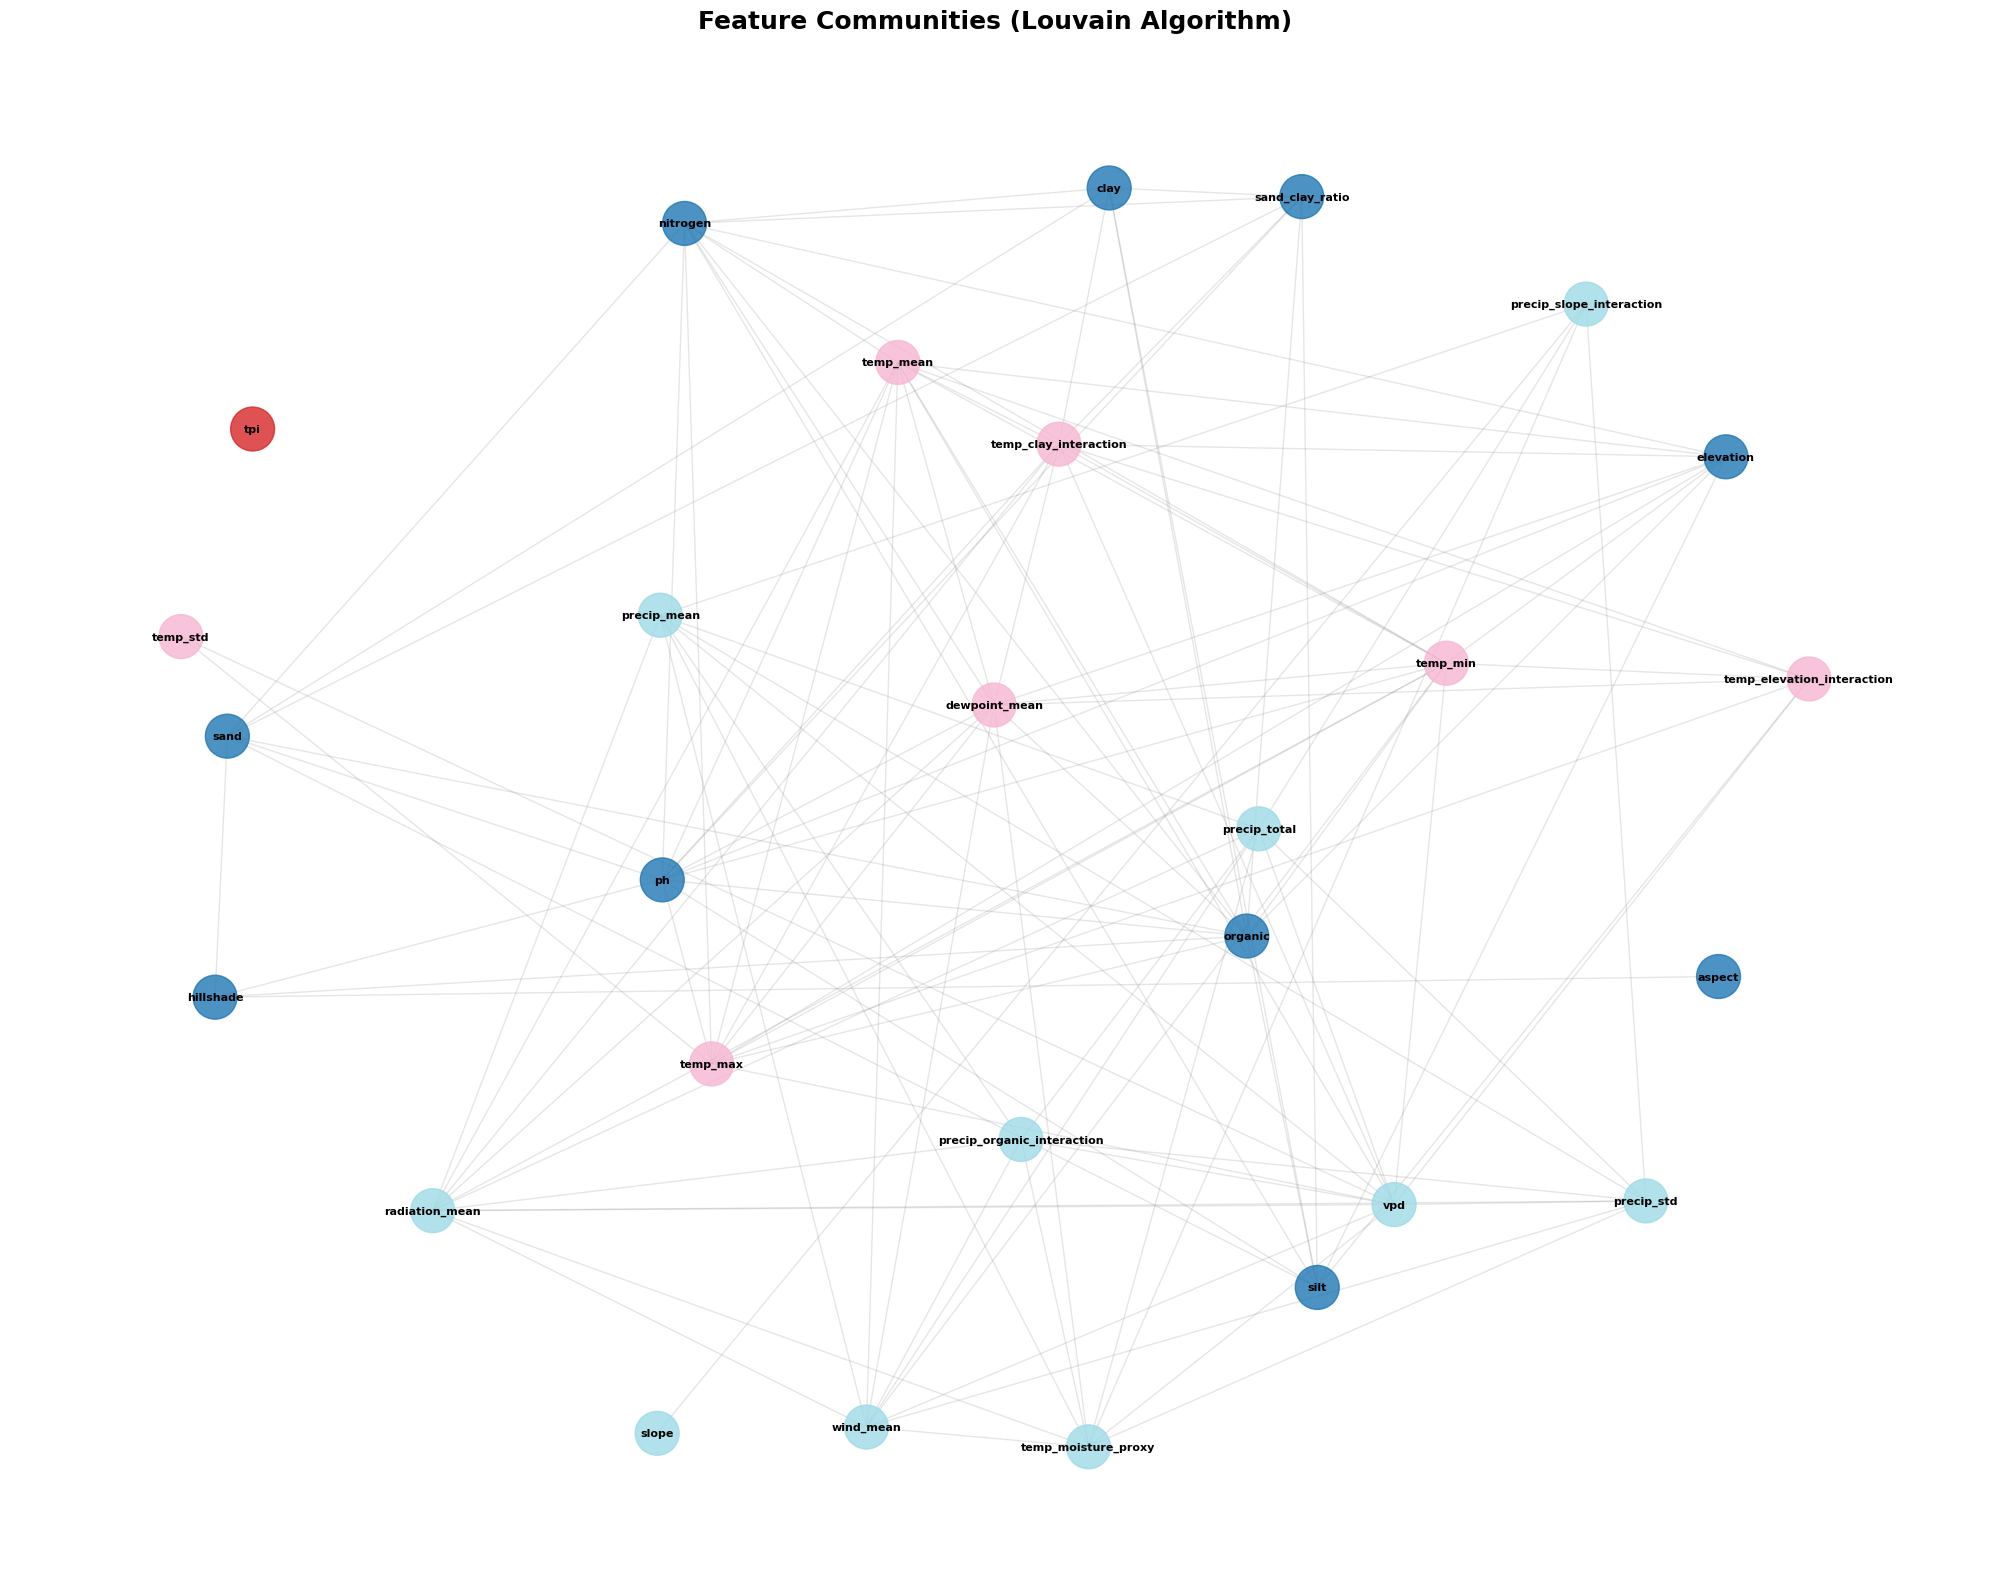

In [7]:
def detect_communities(G, graph_name):
    """Detect communities using multiple algorithms"""
    
    print(f"\nDetecting communities in {graph_name}...")
    
    # Louvain method (best for modularity)
    from networkx.algorithms import community
    
    communities_louvain = community.louvain_communities(G, seed=42)
    
    # Greedy modularity
    communities_greedy = community.greedy_modularity_communities(G)
    
    print(f"✅ Louvain: {len(communities_louvain)} communities")
    print(f"✅ Greedy: {len(communities_greedy)} communities")
    
    # Assign community labels to nodes
    community_map = {}
    for i, comm in enumerate(communities_louvain):
        for node in comm:
            community_map[node] = i
    
    return communities_louvain, community_map

# Detect communities in feature graph
communities_features, community_map_features = detect_communities(
    graph_pearson, "Feature Pearson Graph"
)

# Visualize communities
def visualize_communities(G, community_map, title, filename):
    """Visualize graph with community colors"""
    
    fig, ax = plt.subplots(figsize=(20, 16))
    
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
    
    # Color by community
    node_colors = [community_map.get(node, 0) for node in G.nodes()]
    
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, 
                          cmap='tab20', node_size=1000, alpha=0.8, ax=ax)
    nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='gray', ax=ax)
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold', ax=ax)
    
    ax.set_title(title, fontsize=18, fontweight='bold', pad=20)
    ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✅ Community visualization saved: {filename}")

visualize_communities(
    graph_pearson,
    community_map_features,
    'Feature Communities (Louvain Algorithm)',
    './data_output/graph_communities_features.png'
)

# Print community composition
print("\n📊 Community Composition:")
for i, comm in enumerate(communities_features):
    print(f"\nCommunity {i+1} ({len(comm)} features):")
    for node in sorted(comm):
        category = graph_pearson.nodes[node]['category']
        print(f"  - {node} ({category})")

#### ============================================================================
<h3 align="center">SECTION 7: EXPORT GRAPHS FOR GNN MODELING</h3>

#### ============================================================================

In [9]:
def export_graph_for_gnn(G, features_df, filename_prefix):
    """
    Export graph in format suitable for PyTorch Geometric
    
    Returns:
    --------
    - Edge list (CSV)
    - Node features (CSV)
    - Graph structure (GraphML)
    """
    
    print(f"Exporting graph: {filename_prefix}...")
    
    # Create a sanitized copy of the graph for GraphML export
    G_sanitized = G.copy()
    
    # Convert all attributes to GraphML-compatible types (string, int, float, bool)
    for node, data in G_sanitized.nodes(data=True):
        for key, value in list(data.items()):
            if isinstance(value, (tuple, list, dict, set)):
                # Convert complex types to string representation
                G_sanitized.nodes[node][key] = str(value)
            elif isinstance(value, (np.int32, np.int64, np.float32, np.float64)):
                # Convert numpy types to Python native types
                G_sanitized.nodes[node][key] = value.item()
    
    for u, v, data in G_sanitized.edges(data=True):
        for key, value in list(data.items()):
            if isinstance(value, (tuple, list, dict, set)):
                # Convert complex types to string representation
                G_sanitized[u][v][key] = str(value)
            elif isinstance(value, (np.int32, np.int64, np.float32, np.float64)):
                # Convert numpy types to Python native types
                G_sanitized[u][v][key] = value.item()
    
    # Edge list
    edge_list = []
    for u, v, data in G.edges(data=True):
        edge_list.append({
            'source': u,
            'target': v,
            'weight': data.get('weight', 1.0)
        })
    edge_df = pd.DataFrame(edge_list)
    edge_df.to_csv(f'./data_output/{filename_prefix}_edges.csv', index=False)
    
    # Node attributes
    node_attrs = []
    for node in G.nodes():
        attrs = {'node_id': node}
        # Add all node attributes, converting tuples to strings
        for key, value in G.nodes[node].items():
            if isinstance(value, tuple):
                attrs[key] = str(value)
            else:
                attrs[key] = value
        node_attrs.append(attrs)
    node_df = pd.DataFrame(node_attrs)
    node_df.to_csv(f'./data_output/{filename_prefix}_nodes.csv', index=False)
    
    # Save as GraphML using sanitized graph
    try:
        nx.write_graphml(G_sanitized, f'./data_output/{filename_prefix}.graphml')
        print(f"✅ GraphML exported: {filename_prefix}.graphml")
    except Exception as e:
        print(f"⚠️  GraphML export failed: {e}")
        print("   Exporting only CSV files...")
    
    # Alternative export formats
    try:
        # GEXF format (more flexible than GraphML)
        nx.write_gexf(G, f'./data_output/{filename_prefix}.gexf')
        print(f"✅ GEXF exported: {filename_prefix}.gexf")
    except Exception as e:
        print(f"⚠️  GEXF export failed: {e}")
    
    print(f"✅ Exported: {filename_prefix}")
    print(f"   Edges: {len(edge_df)}")
    print(f"   Nodes: {len(node_df)}")

# Export graphs
export_graph_for_gnn(graph_pearson, data, 'graph_feature_pearson')
export_graph_for_gnn(graph_mi, data, 'graph_feature_mi')
export_graph_for_gnn(spatial_graph, data, 'graph_spatial')

Exporting graph: graph_feature_pearson...
✅ GraphML exported: graph_feature_pearson.graphml
✅ GEXF exported: graph_feature_pearson.gexf
✅ Exported: graph_feature_pearson
   Edges: 112
   Nodes: 28
Exporting graph: graph_feature_mi...
✅ GraphML exported: graph_feature_mi.graphml
✅ GEXF exported: graph_feature_mi.gexf
✅ Exported: graph_feature_mi
   Edges: 276
   Nodes: 28
Exporting graph: graph_spatial...
✅ GraphML exported: graph_spatial.graphml
⚠️  GEXF export failed: attribute value type is not allowed: <class 'tuple'>
✅ Exported: graph_spatial
   Edges: 472905
   Nodes: 1000


#### ============================================================================
<h3 align="center">SECTION 8: GRAPH SUMMARY STATISTICS</h3>

#### ============================================================================

In [11]:
summary = {
    'Feature Interaction Graph (Pearson)': {
        'Nodes': graph_pearson.number_of_nodes(),
        'Edges': graph_pearson.number_of_edges(),
        'Density': nx.density(graph_pearson),
        'Communities': len(communities_features)
    },
    'Feature Interaction Graph (MI)': {
        'Nodes': graph_mi.number_of_nodes(),
        'Edges': graph_mi.number_of_edges(),
        'Density': nx.density(graph_mi)
    },
    'Spatial Proximity Graph': {
        'Nodes': spatial_graph.number_of_nodes(),
        'Edges': spatial_graph.number_of_edges(),
        'Density': nx.density(spatial_graph)
    }
}

print("\n📊 Graph Statistics Summary:")
for graph_name, stats in summary.items():
    print(f"\n{graph_name}:")
    for metric, value in stats.items():
        print(f"  {metric}: {value:.4f}" if isinstance(value, float) else f"  {metric}: {value}")

# Save summary
with open('./data_output/graph_summary_report.txt', 'w') as f:
    f.write("="*70 + "\n")
    f.write("GRAPH CONSTRUCTION - SUMMARY REPORT\n")
    f.write("="*70 + "\n\n")
    
    for graph_name, stats in summary.items():
        f.write(f"\n{graph_name}:\n")
        f.write("-" * 50 + "\n")
        for metric, value in stats.items():
            if isinstance(value, float):
                f.write(f"{metric}: {value:.4f}\n")
            else:
                f.write(f"{metric}: {value}\n")

print("\n✅ Graph construction complete!")
print("   All graphs exported for GNN modeling")
print("   Files saved to ./data_output/")
print("\n" + "="*70)


📊 Graph Statistics Summary:

Feature Interaction Graph (Pearson):
  Nodes: 28
  Edges: 112
  Density: 0.2963
  Communities: 4

Feature Interaction Graph (MI):
  Nodes: 28
  Edges: 276
  Density: 0.7302

Spatial Proximity Graph:
  Nodes: 1000
  Edges: 472905
  Density: 0.9468

✅ Graph construction complete!
   All graphs exported for GNN modeling
   Files saved to ./data_output/

